In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from cereeberus import ReebGraph, MapperGraph, Interleave, Assignment
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

import time
import random
from tqdm import tqdm
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm  # progress bar


In [4]:
def run_single(torus_params, line_params, reps=10):
    temp_total_time = []
    temp_optimization_time = []

    for _ in range(reps):
        start = time.perf_counter()
        myInt = Interleave(ex_mg.torus(**torus_params),
                           ex_mg.line(**line_params))
        opt_start = time.perf_counter()
        myInt.fit()
        end = time.perf_counter()

        temp_total_time.append(end - start)
        temp_optimization_time.append(end - opt_start)

    return (np.mean(temp_total_time), np.std(temp_total_time),
            np.mean(temp_optimization_time), np.std(temp_optimization_time))


In [5]:


# Warm-up run
torus_warm = ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42)
line_warm = ex_mg.line(a=0, b=6, seed=0)
warm = Interleave(torus_warm, line_warm)
warm.fit()


1

In [6]:

# Prepare experiment parameters
param_list = []
for i in range(1, 51):
    torus_params = dict(a=0, b=2, c=i+2, d=i+4, delta=1, seed=42)
    line_params = dict(a=0, b=i+4, seed=0)
    param_list.append((torus_params, line_params))

# Parallel execution with progress bar
n_cores = 32c
results = []
print(f"Using {n_cores} cores for parallel execution.")
with ProcessPoolExecutor(max_workers=n_cores) as executor:
    futures = {executor.submit(run_single, t, l): i for i, (t, l) in enumerate(param_list)}
    for f in tqdm(as_completed(futures), total=len(futures), desc="Running experiments"):
        results.append(f.result())

# Sort results by experiment index (optional)
results = [results[i] for i in range(len(results))]

# Unpack results
total_time = [(r[0], r[1]) for r in results]
optimization_time = [(r[2], r[3]) for r in results]

# Export to CSV
df = pd.DataFrame({
    "loop_size": list(range(1, 51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
})
df.to_csv("torus_line_benchmark.csv", index=False)

print("Benchmark completed and CSV saved!")

Using 32 cores for parallel execution.


Running experiments: 100%|██████████| 50/50 [1:27:56<00:00, 105.53s/it]

Benchmark completed and CSV saved!


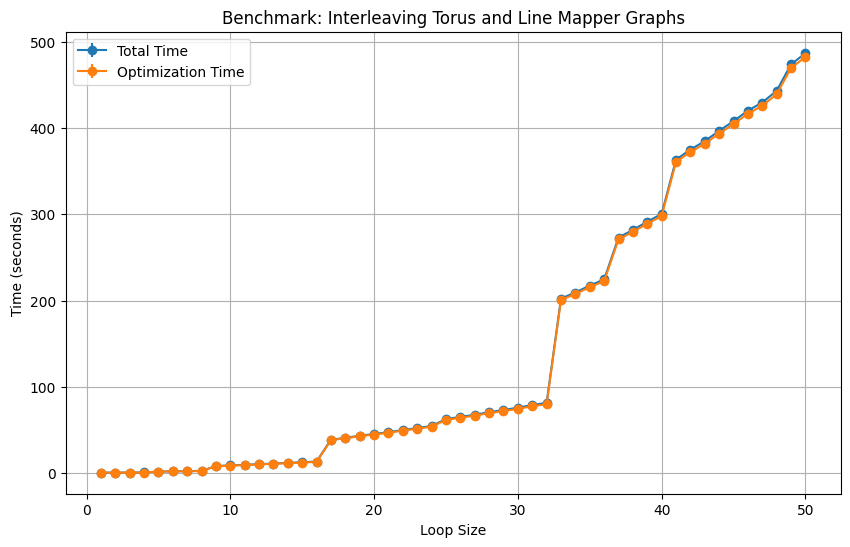

In [7]:
# visualize results
plt.figure(figsize=(10, 6))
plt.errorbar(df["loop_size"], df["total_time_mean"], yerr=df["total_time_std"], label='Total Time', fmt='-o')
plt.errorbar(df["loop_size"], df["optimization_time_mean"], yerr=df["optimization_time_std"], label='Optimization Time', fmt='-o')
plt.xlabel('Loop Size')
plt.ylabel('Time (seconds)')
plt.title('Benchmark: Interleaving Torus and Line Mapper Graphs')
plt.legend()
plt.grid()
plt.savefig("torus_line_benchmark.png") 

In [8]:
def run_single_dist(torus_params, line_params, reps=10):
    temp_total_time = []
    temp_optimization_time = []

    for _ in range(reps):
        start = time.perf_counter()
        myInt = Interleave(ex_mg.torus(**torus_params),
                           ex_mg.line(**line_params))
        opt_start = time.perf_counter()
        myInt.dist_fit()
        end = time.perf_counter()

        temp_total_time.append(end - start)
        temp_optimization_time.append(end - opt_start)

    return (np.mean(temp_total_time), np.std(temp_total_time),
            np.mean(temp_optimization_time), np.std(temp_optimization_time))


In [9]:


# Warm-up run
torus_warm = ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42)
line_warm = ex_mg.line(a=0, b=6, seed=0)
warm = Interleave(torus_warm, line_warm)
warm.dist_fit()

1

In [10]:
# Prepare experiment parameters
param_list = []
for i in range(1, 51):
    torus_params = dict(a=0, b=2, c=i+2, d=i+4, delta=1, seed=42)
    line_params = dict(a=0, b=i+4, seed=0)
    param_list.append((torus_params, line_params))

# Parallel execution with progress bar
n_cores = 32
dist_results = []
print(f"Using {n_cores} cores for parallel execution.")
with ProcessPoolExecutor(max_workers=n_cores) as executor:
    futures = {executor.submit(run_single_dist, t, l): i for i, (t, l) in enumerate(param_list)}
    for f in tqdm(as_completed(futures), total=len(futures), desc="Running experiments"):
        dist_results.append(f.result())

# Sort results by experiment index (optional)
dist_results = [dist_results[i] for i in range(len(dist_results))]

# Unpack results
total_time = [(r[0], r[1]) for r in dist_results]
optimization_time = [(r[2], r[3]) for r in dist_results]

# Export to CSV
df_dist = pd.DataFrame({
    "loop_size": list(range(1, 51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
})
df_dist.to_csv("torus_line_benchmark_dist.csv", index=False)

print("Benchmark completed and CSV saved!") 

Using 32 cores for parallel execution.


Running experiments: 100%|██████████| 50/50 [1:27:56<00:00, 105.53s/it]

Benchmark completed and CSV saved!


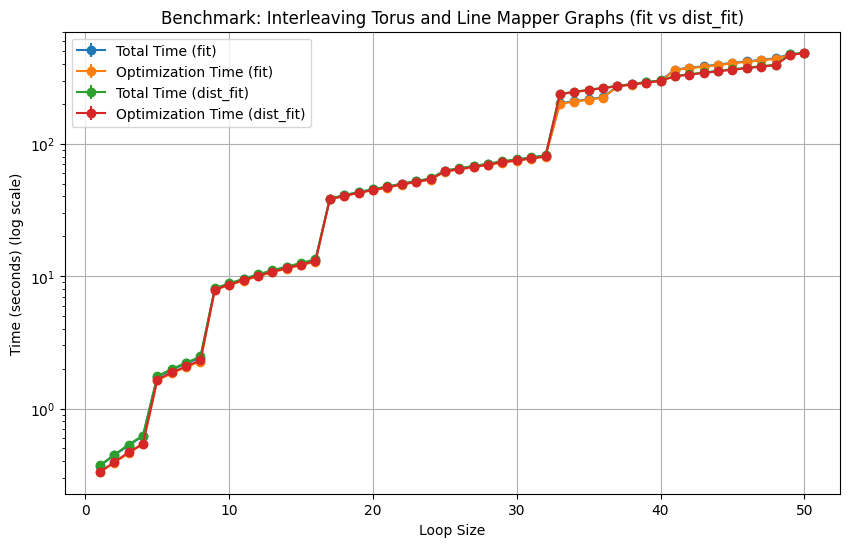

In [6]:
#plot both results

df1 = pd.read_csv("torus_line_benchmark.csv")
df2 = pd.read_csv("torus_line_benchmark_dist.csv")

plt.figure(figsize=(10, 6))
plt.errorbar(df1["loop_size"], df1["total_time_mean"], yerr=df1["total_time_std"], label='Total Time (fit)', fmt='-o')
plt.errorbar(df1["loop_size"], df1["optimization_time_mean"], yerr=df1["optimization_time_std"], label='Optimization Time (fit)', fmt='-o')
plt.errorbar(df2["loop_size"], df2["total_time_mean"], yerr=df2["total_time_std"], label='Total Time (dist_fit)', fmt='-o')
plt.errorbar(df2["loop_size"], df2["optimization_time_mean"], yerr=df2["optimization_time_std"], label='Optimization Time (dist_fit)', fmt='-o')
plt.xlabel('Loop Size')
plt.ylabel('Time (seconds) (log scale)')
plt.title('Benchmark: Interleaving Torus and Line Mapper Graphs (fit vs dist_fit)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.savefig("torus_line_benchmark_comparison.png")